<h1 style="text-align: center">WMM - Laboratorium 1. - Analiza sygnałów</h1>

## Importowanie bibliotek

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

## Funkcje pomocnicze

In [10]:
def make_signal(function, pulsation, amplitude=1):
    return (lambda t: amplitude* function(pulsation * t)), 2 * np.pi / pulsation

def sample_signal(signal, period, num_samples, sampling_frequency=None):
    freq = 1 / period
    if sampling_frequency is not None:
        delta_t = 1 / sampling_frequency
        period = num_samples * delta_t
    else:
        delta_t = period / num_samples
    dirac_d = np.arange(0, period, delta_t)
    delta_f = freq / num_samples
    buckets = np.arange(0, freq, delta_f)
    return signal(dirac_d), dirac_d, buckets

make_discrete_signal = lambda signal, num_samples: sample_signal(signal, num_samples, num_samples)[0]



# Zadanie 1
Liczba próbek (w jednym okresie) sygnału rzeczywistego s(t)=sin(2πt) wynosi N, gdzie N jest potęgą 2.

a) Przyjmując N = 8 wykreślić przebieg sygnału spróbkowanego, widmo amplitudowe i fazowe oraz zweryfikować eksperymentalnie słuszność twierdzenia Parsevala.

b) Wykreślić wykres przedstawiający czas wyznaczania widma sygnału dyskretnego za pomocą algorytmu FFT w funkcji liczby próbek N=2^l, 
l∈{3,4,5,6,7,8,9,10,11,12}. 

Skomentować kształt otrzymanego wykresu odnosząc się do teoretycznej złożoności obliczeniowej algorytmu FFT.

## Spróbkowanie sygnału i wyznaczenie widm

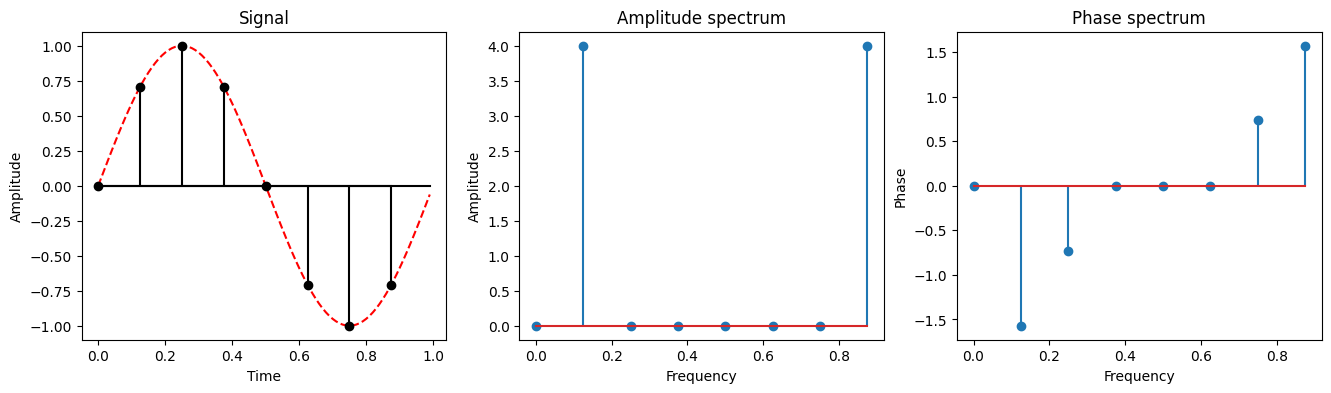

In [21]:
N = 8
sin, period = make_signal(
    function=np.sin, 
    pulsation=2 * np.pi
)

samples, probing_signal, buckets = sample_signal(sin, period, N)
spectrum = np.fft.fft(samples)
freq_spectrum = np.abs(spectrum)
phase_spectrum = np.angle(spectrum)

X_cont = np.arange(0, period, 0.01)

_, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(X_cont, sin(X_cont), "--", color="red")
ax[0].stem(probing_signal, samples, linefmt='k-', markerfmt='o', basefmt='k-')
ax[0].plot(X_cont, np.zeros(X_cont.shape), color="black")  # line
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Signal")

ax[1].stem(buckets, freq_spectrum)
ax[1].set_title("Amplitude spectrum")
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Amplitude")

ax[2].stem(buckets, phase_spectrum)
ax[2].set_title("Phase spectrum")
ax[2].set_xlabel("Frequency")
ax[2].set_ylabel("Phase")

plt.show()

## Weryfikacja twierdzenia Parsevala
$$ \sum_{n=0}^{N-1} |x[n]|^2 = \frac{1}{N} \sum_{k=0}^{N-1} |X[k]|^2 $$

In [12]:
sum_abs_squares = lambda x: np.sum(np.abs(x)**2)

sum_abs_squares(samples) == 1/N * sum_abs_squares(spectrum)


True

Moc policzona bezpośrednio z sygnału jest równa mocy wyliczonej na podstawie widma, zatem potwierdza to słuszność tw. Parsevala

## Czas wykonania FFT w zależności od liczby próbek

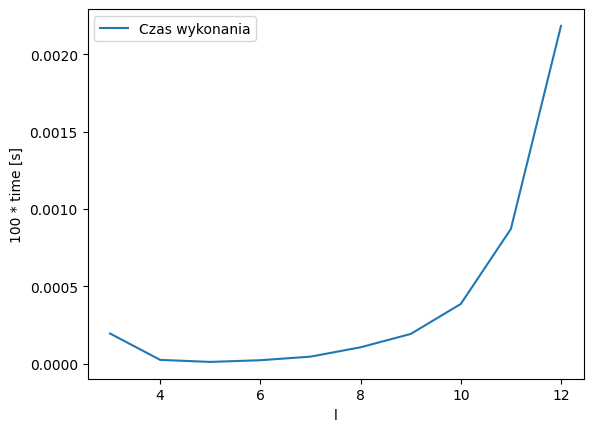

In [104]:
tested_n = [2**(2*n) for n in range(3, 13)]
results = []
for n in tested_n:
    t = np.linspace(0, 2, n)
    samples = sin(t)
    start = timer()
    np.fft.fft(samples)
    results.append(timer() - start)
    

_, ax = plt.subplots()

ax.plot(tested_n, results)
ax.set_xlabel("l")
ax.set_ylabel("100 * time [s]")

plt.legend(["Czas wykonania", "O(n^2)"])


plt.show()

Teoretyczna złożoność obliczeniowa algorytmu FFT to nlog(n), natomiast u nas wykres wskazuje bardziej na złozoność liniową, wynika to zapewne stąd, że dla małych wartości wykres nlog(n) jest podobny do wykresu funkcji liniowej

# Zadanie 2

Zbadać wpływ przesunięcia w czasie na postać widma amplitudowego i widma fazowego dyskretnego
sygnału harmonicznego
$$ s[n]=Asin(\frac{2\pi n}{N}) $$
o amplitudzie A = 2 i okresie podstawowym N 88. W tym celu dla każdej wartości
$$ n_0 ∈ \{0, \frac{N}{4}, \frac{N}{2}, \frac{3N}{4} \} $$
wykreślić widmo amplitudowe i fazowe przesuniętego sygnału
$$ s[n-n_0]_N $$

Skomentować otrzymane wyniki.


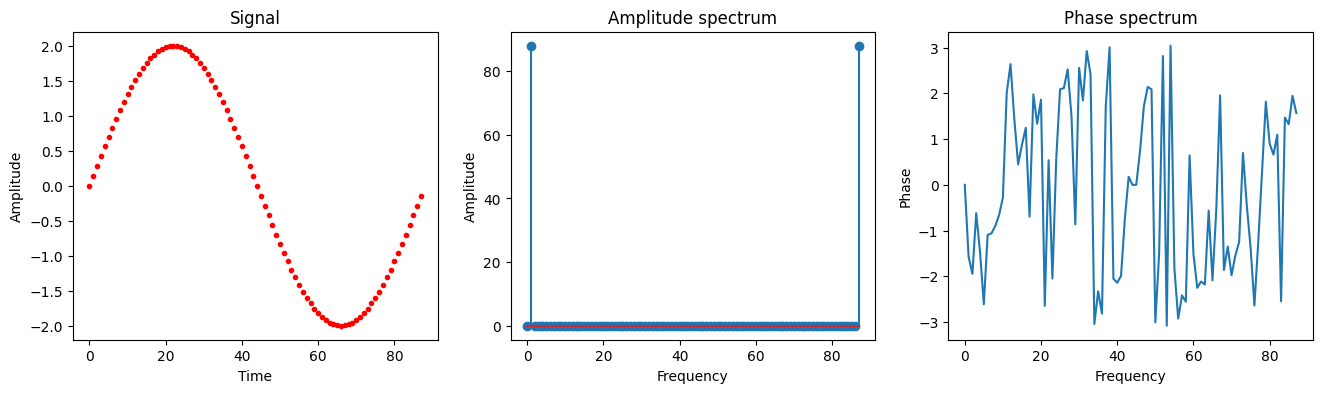

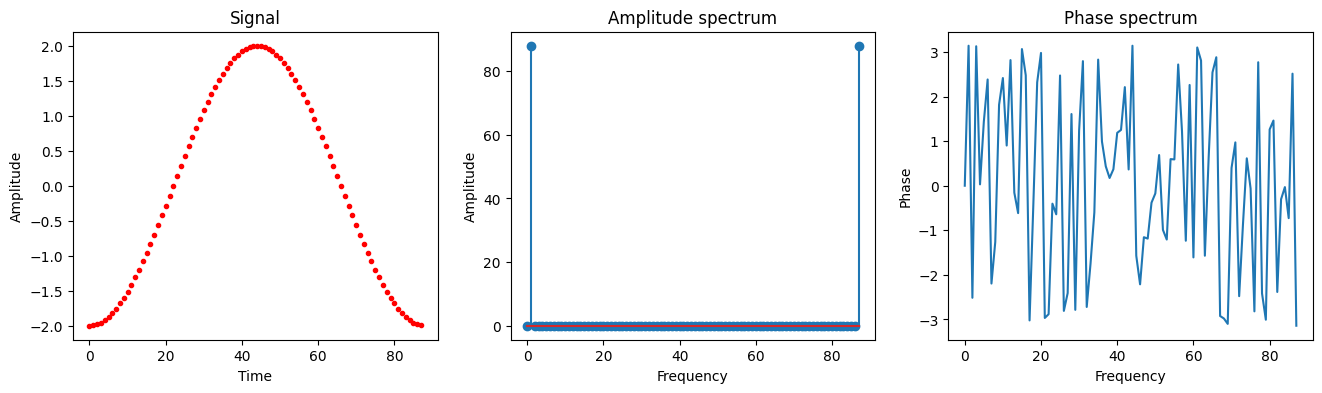

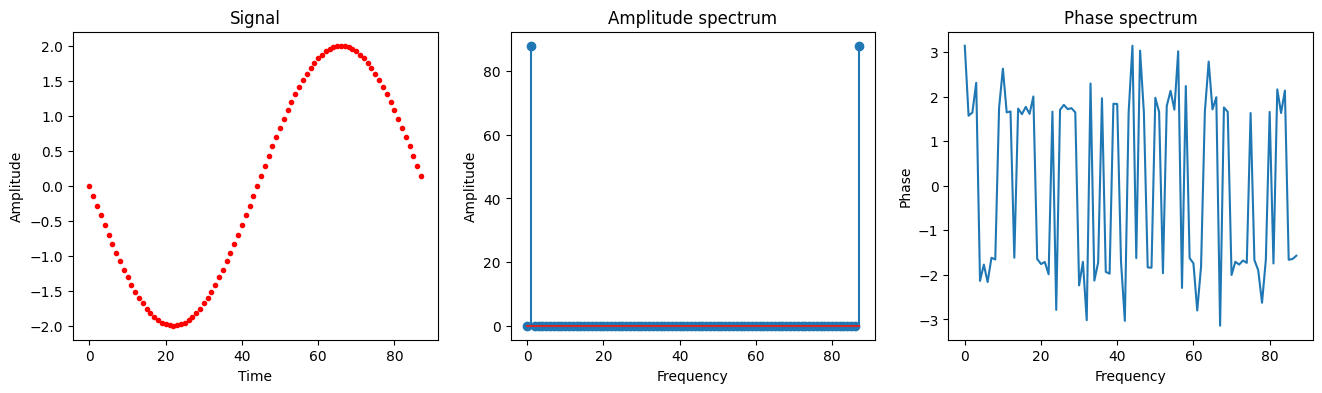

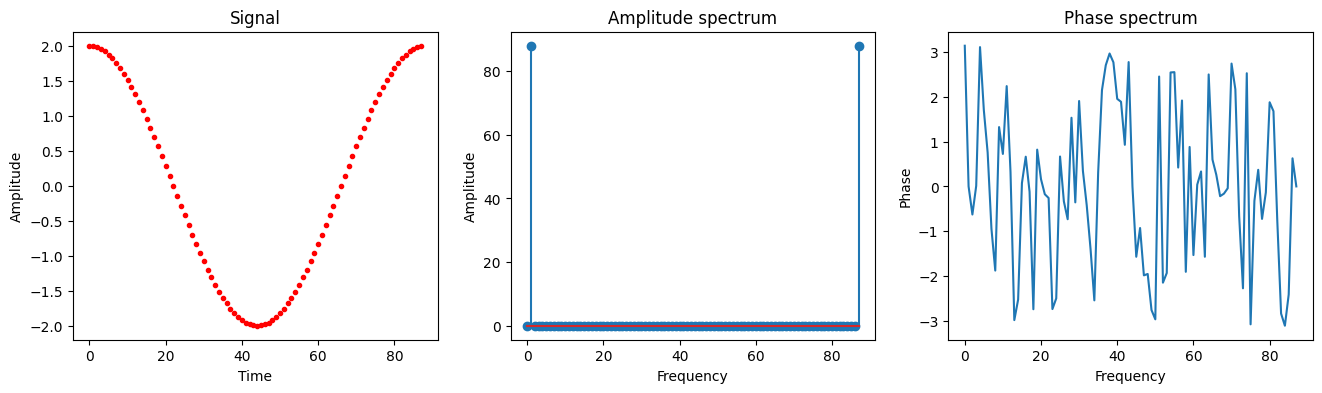

In [76]:
N = 88
A = 2
shifts = [0, N/4, N/2, 3*N/4]
sin, _ = make_signal(
        function=np.sin, 
        pulsation=2 * np.pi / N, 
        amplitude=A
    )

for shift in shifts:   
    shifted = lambda n: sin(n - shift)
    
    samples = make_discrete_signal(shifted, N)
    
    spectrum = np.fft.fft(samples)
    freq_spectrum = np.abs(spectrum)
    phase_spectrum = np.angle(spectrum)
    
    _, ax = plt.subplots(1, 3, figsize=(16, 4))
    
    ax[0].plot(samples, ".", color="red")
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Amplitude")
    ax[0].set_title("Signal")
    ax[1].stem(freq_spectrum)
    ax[1].set_title("Amplitude spectrum")
    ax[1].set_xlabel("Frequency")
    ax[1].set_ylabel("Amplitude")
    ax[2].plot(phase_spectrum)
    ax[2].set_title("Phase spectrum")
    ax[2].set_xlabel("Frequency")
    ax[2].set_ylabel("Phase")
    
plt.show()


Otrzymaliśmy wyniki zgodnie ze wzorem na przesunięcie sygnału w dziedzinie czasu:
$$ x(t - t_0) = X(N)e^{\frac{-j2\pi t_0}{N}} $$

Przesunięcie w dziedzinie czasu nie powoduje zmian widma amplitudowego, ponieważ dany punkt z widma obracamy jedynie wokół środka zespolonego układu wspołrzędnych, zatem amplituda czyli odległość tego punktu od środa się nie zmienia.

Zmienić natomiast powinno się widmo fazowe i to obserwujemy na wykresach.



# Zadanie 3
Zbadać wpływ dopełnienia zerami na postać widma amplitudowego i widma fazowego dyskretnego sygnału
$$ s[n] = A(1 - \frac{n\ mod\ N}{N}) $$
o amplitudzie A=4 i okresie podstawowym N=12. W tym celu dla każdej wartości
$$ n_0 ∈ \{0, 1N, 4N, 9N \} $$
wykreślić widmo amplitudowe i fazowe sygnału
s[n] dopełnionego N0 zerami. Skomentować otrzymane wyniki.

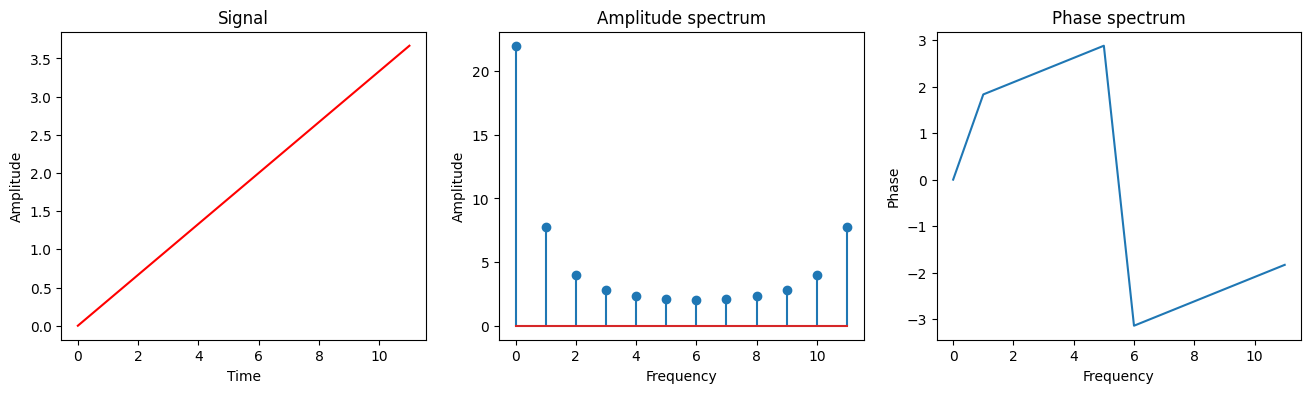

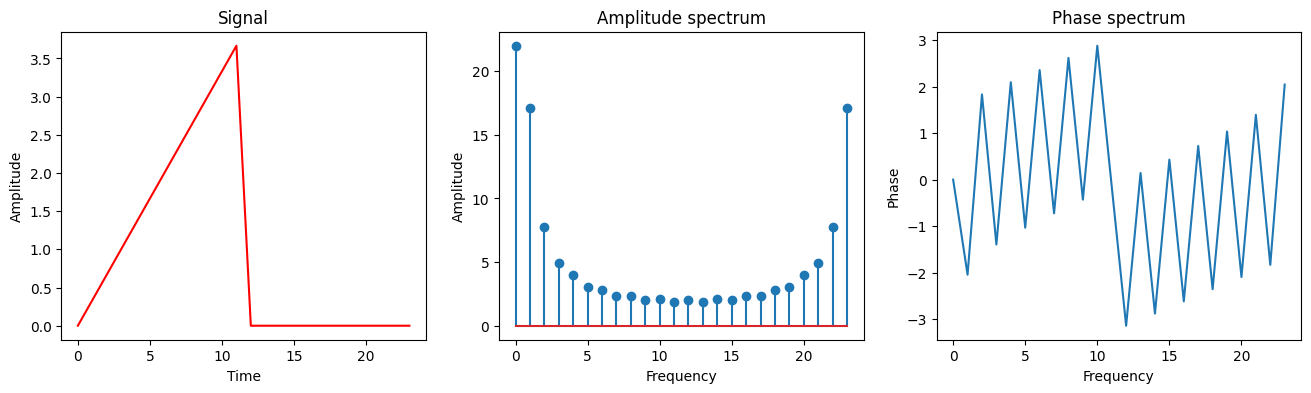

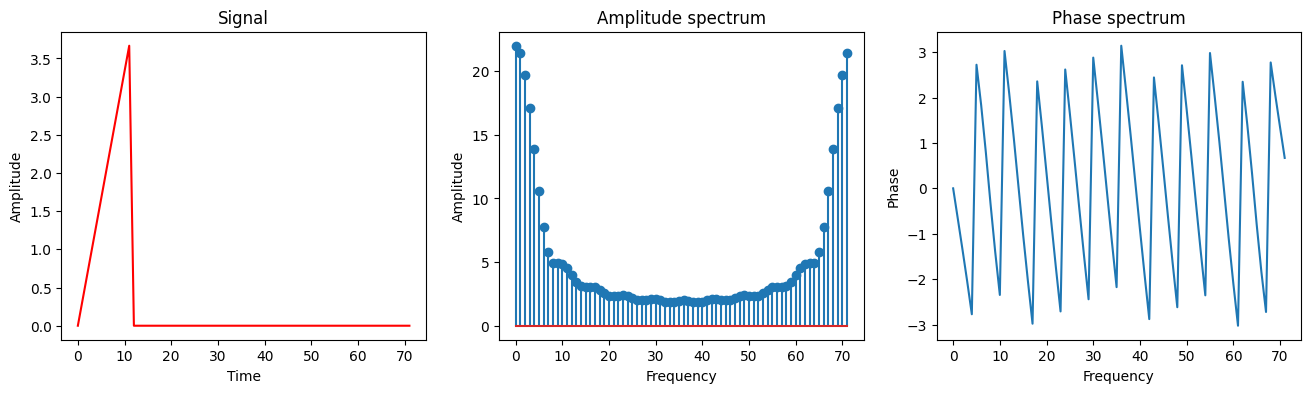

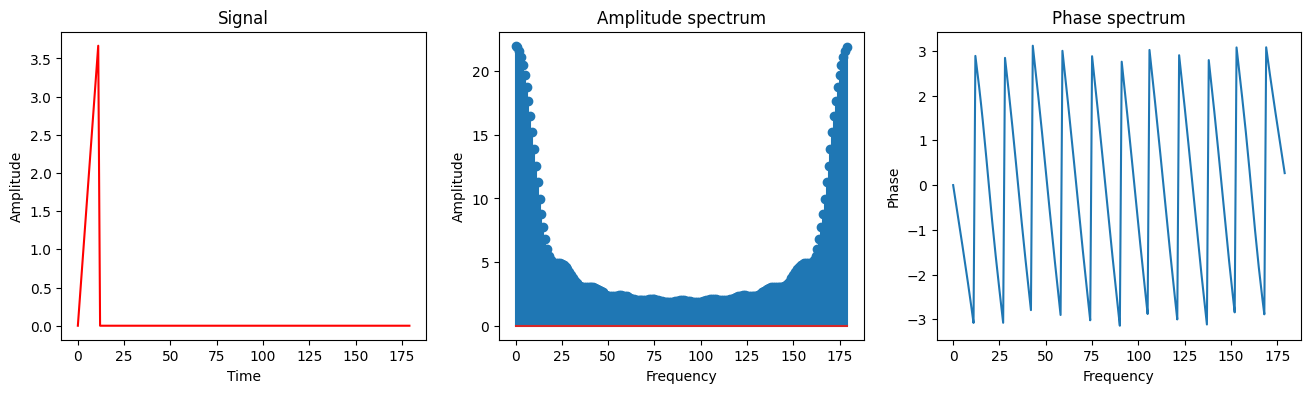

In [73]:
A = 4
N = 12
signal = lambda n: A * (np.mod(n, N) / N)
samples = make_discrete_signal(signal, N)

n_zeros_list = [0, N, 4*N, 9*N]
    
for n_zeros in n_zeros_list:
    samples = np.concatenate((samples, np.zeros(n_zeros)))
    spectrum = np.fft.fft(samples)
    freq_spectrum = np.abs(spectrum)
    phase_spectrum = np.angle(spectrum)
    
    _, ax = plt.subplots(1, 3, figsize=(16, 4))
    
    ax[0].plot(samples, "-", color="red")
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Amplitude")
    ax[0].set_title("Signal")
    ax[1].stem(freq_spectrum)
    ax[1].set_title("Amplitude spectrum")
    ax[1].set_xlabel("Frequency")
    ax[1].set_ylabel("Amplitude")
    ax[2].plot(phase_spectrum)
    ax[2].set_title("Phase spectrum")
    ax[2].set_xlabel("Frequency")
    ax[2].set_ylabel("Phase")
    


Zarówno na wykresach widm amplitudowych jak i fazowych obserwujemy rozciągnięcie wykresu w poziomie.
Dopełnienie sygnału zerami sprawia, że widmo ma wyższą rozdzielczość. Dzieje się tak ponieważ dopełniając zwiększamy parametr N w sygnale, co z kolei zwiększa liczbę punktów w widmie i zmniejsza rozmiary _kubełków_ częstotliwości w widmie. Dzięki temu dostajemy bardziej szczegółowy wykres.

# Zadanie 4
Dany jest sygnał rzeczywisty:
$$ s(t)=A_1sin(2\pi f_1t) + A_2sin(2\pi f_2t) + A_3sin(2\pi f_3t) $$
, gdzie $$ A_1=0.1, f_1=3000 Hz, A_2=0.7, f_2=8000 Hz, A_3=0.9, f_3=11000 Hz$$
Przy założeniu, że częstotliwość próbkowania wynosi `fs=48000 Hz`, a liczba próbek sygnału wynosi `N1=2048`, przedstawić wykres widmowej gęstości mocy sygnału s(t). Czy dla podanej liczby próbek mamy do czynienia ze zjawiskiem przecieku widma? Czy dla liczby próbek
$$ N_2=\frac{3}{2}N$$
sytuacja ulegnie zmianie? Odpowiedź uzasadnić.


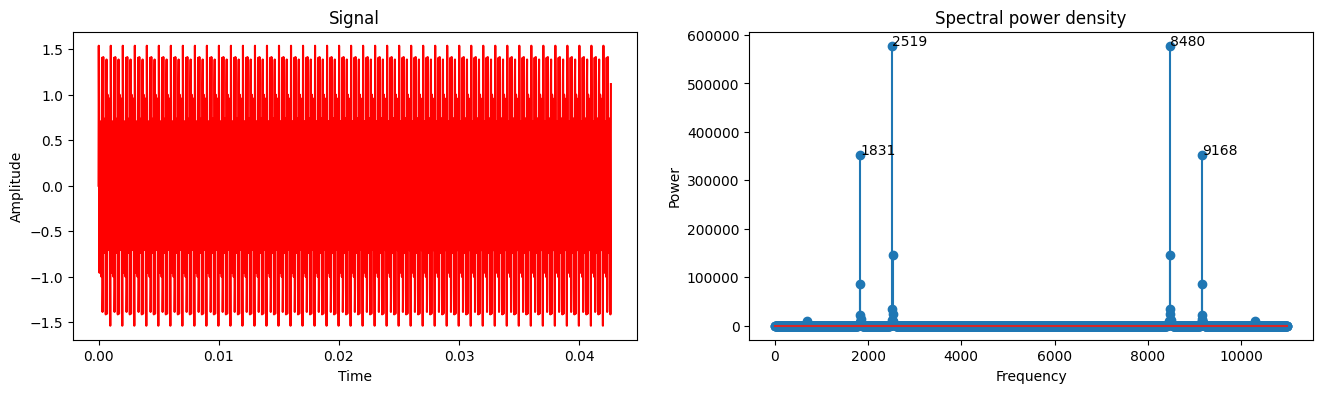

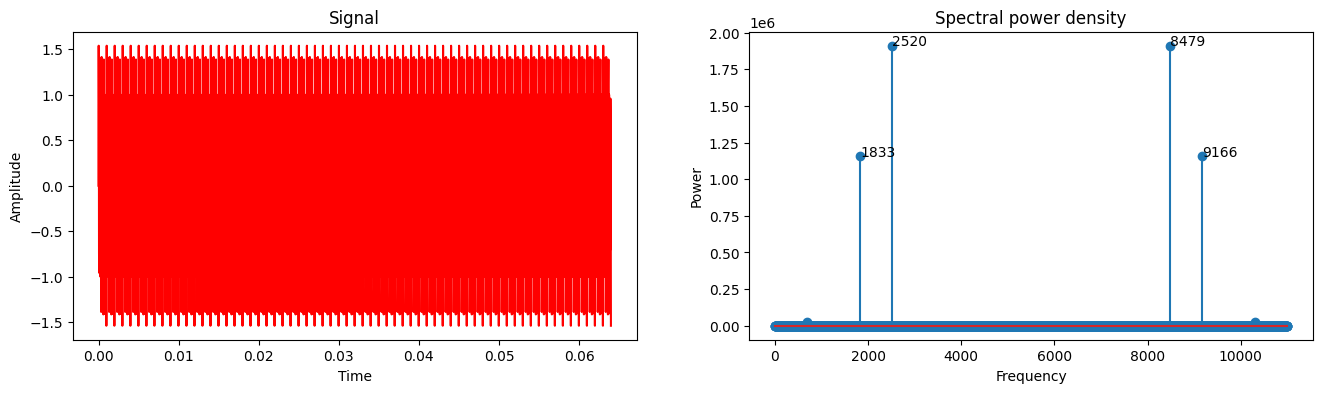

In [74]:
A_list = [0.1, 0.7, 0.9]
f_list = [3000, 8000, 11000]
N = 2048
sampling_frequency = 48000
largest_frequency = f_list[-1]
sampling_period = 1/sampling_frequency
n_labels = 4

signal = lambda x: sum([A * np.sin(2 * np.pi * f * x) for A, f in zip(A_list, f_list)])


samples, probing_signal, buckets = sample_signal(signal, 1/largest_frequency, N, sampling_frequency)
spectrum = np.fft.fft(samples)
spectral_power_density = np.abs(spectrum)**2

_, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(probing_signal, samples, "-", color="red")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Signal")

ax[1].stem(buckets, spectral_power_density)
ax[1].set_title("Spectral power density")
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Power")

largest_indices = np.argsort(spectral_power_density)[-n_labels:]  

for i in largest_indices:
    ax[1].annotate(f'{int(buckets[i])}', xy=(buckets[i], spectral_power_density[i]))


N = (3/2) * N

samples, probing_signal, buckets = sample_signal(signal, 1/largest_frequency, N, sampling_frequency)
spectrum = np.fft.fft(samples)
spectral_power_density = np.abs(spectrum)**2

_, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(probing_signal, samples, "-", color="red")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Signal")
ax[1].stem(buckets, spectral_power_density)
ax[1].set_title("Spectral power density")
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Power")

largest_indices = np.argsort(spectral_power_density)[-n_labels:]  

for i in largest_indices:
    ax[1].annotate(f'{int(buckets[i])}', xy=(buckets[i], spectral_power_density[i]))

plt.show()

W pierwszym przypadku obserwujemy zjawisko przecieku widma, natomiast kiedy zwiększymy liczbę próbek do 3N/2 to problem jest rozwiązany. Jest to związane z końcem okresu próbkowania, jeśli skonczymy próbkowanie w miejscu, w którym kończy się okres funkcji, to nie będzie przecieku widma. Można się upewnić korzystając ze wzoru:
$$\frac{f_s}{NWD(f_1, f_2, f_3)} = 48000 / 1000 = 48 $$
2048 nie jest podzielne przez 48 więc występuje przeciek, 3/2 * 2048 = 3072, które jest podzielne przez 48 - nie ma przecieku.